#### Note:
Now synaptic failures to transmit spikes are implemented

## Parameters

In [10]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm_notebook as tqdm

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~!All needed to be defined!~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

dt = 0.1    # update time scale (ms)

              # Populations properties (Adapted from Gittis et al. 2010 & Taverna et al. 2008) #
class Population:
    NN       =     np.array([490, 490, 20])             # neuron numbers
    Tag      =     {"dSPN":0, "iSPN":1, "FSI":2}        # number labels starting from 0
    Colors   =     np.array([[0, 0, 1],
                             [0, 1, 0],
                             [1, 0, 0]])                # colors for plots
    size = len(NN)

    # connectivity parameters of populations (from column to rows)
    CP       =     np.array([[0.26, 0.27, 0.53], 
                             [0.06, 0.36, 0.36], 
                             [0, 0, 0.58]])             # connectivity probabilities
    CW       =     np.array([[-0.4, -1.3, -5], 
                             [-1.1, -1.1, -5], 
                             [0, 0, -0.6]])             # connectivity weigths (mv.ms/spike), negative is inhibitory
    mod      =     10                                   # connectivity strength
    CW       =     CW*mod    
    
    
    # single neuron parameters of populations
    Tau      =     np.array([10, 10, 10])               # decay time constants (ms)
    
    
    # synaptic parameters
    Tausyn   =     10                                   # synaptic time constants for all synapses (ms)
    
    # synaptic failures
    consider_failure = False                            # turns failure calculations on or off (True or False)
    FailRate =     np.array([[0.7, 0.5, 0],
                             [0.7, 0.6, 0],
                             [0, 0, 0]])                # failure rates of spike transfer of synapses (between 0 to 1)
    failure_update_steps = 50/dt                        # number of steps to update stochastic failure matrix for spikes (ms/dt)

    
    # LIF parameters
    Vthr     =     np.array([-50, -50, -50])            # threshold voltage (mv)
    Vreset   =     np.array([-80, -80, -80])            # reset voltage (mv)
    Vrest    =     np.array([-70, -70, -70])            # rest voltage (mv) and initial conditions
    Vspike   =     np.array([40, 40, 40])               # spike voltage (mv)
    
    # external input parameters
    MeanIx   =     np.array([35, 30, 23])               # mean value of external inputs (mv)
    SigmaIx  =     np.array([0, 0, 0])                  # standard deviation [inhomogeneity] of external inputs for differnt neurons (mv)
    
    # noise on neurons parameters
    SigmaNoise =   np.array([2, 2, 2])                  # standard deviation of Gaussian noise [in space and time] input on neurons (mv)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    # to be calculated using mean dynamics of population
    MeanSpikeRate  =   np.array([0, 0, 0])              # mean spike count for each population for the whole time series
    SpikeRate  =   []                                   # spike rate time series in dt bins of populations
    CV         =   []                                   # CV(std/mean) using mean spike count for each population
    AutoCorr   =   []                                   # auto correlation of mean spike count for each population
    ISI        =   []                                   # interspike intervals distribution for each population
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#




## Simulation Functions

In [11]:
def create_Wmat(NN, CP, CW):
    '''
    returns a random weighted connectivity matrix of several 
    neuronal populations with 'NN' as list of neuron population
    numbers, 'CP' as connectivity probability matrix and 'CW'
    as connectivity weight matrix on the population level.
    '''
    nntotal = np.sum(NN) # total number of neurons
    npopulation = len(NN) # number of populations 
    
    
    Wmat = np.array([]) 
    for ind1 in range(npopulation):        
        Rowblock = np.array([])
        for ind2 in range(npopulation):
            # creating weighted connectivity matrix block 
            # of population ind2 to ind1  
            w = CW[ind1, ind2]
            Size = (NN[ind1], NN[ind2]) 
            Prob = [CP[ind1, ind2], 1-CP[ind1, ind2]] # connection probability
            Block = np.random.choice([1, 0], Size, p=Prob)*w # individual block
            Rowblock = np.concatenate((Rowblock, Block), axis=1) if Rowblock.size else Block
        Wmat = np.concatenate((Wmat, Rowblock), axis=0) if Wmat.size else Rowblock
    
    return(Wmat)

def create_Ix():
    ' Creates external input based on the population level mean and sigma ' 
    Ix = []
    for i in range(Population.size):
        PopIx = np.random.normal(Population.MeanIx[i], Population.SigmaIx[i], Population.NN[i])
        Ix    = np.append(Ix, PopIx)
    return Ix

    


#==============================================================================#
                              # Neuron Properties #
class Neuron:
    Tag     =     np.array([i for i in range(Population.NN.size) for j in range(Population.NN[i])]) # Neuron tag
    Colors  =     np.array([Population.Colors[i] for i in Tag])    # colors for plots
    Time    =     []
    
    Tau     =     np.array([Population.Tau[i] for i in Tag])       # single neuron time constant (ms)

    Vthr    =     np.array([Population.Vthr[i] for i in Tag])      # single neuron threshold potential in LIF
    Vreset  =     np.array([Population.Vreset[i] for i in Tag])    # single neuron reset potential in LIF
    Vrest   =     np.array([Population.Vrest[i] for i in Tag])     # single neuron rest potential in LIF
    Vspike  =     np.array([Population.Vspike[i] for i in Tag])    # single neuron spike potential in LIF
    
    Wmat    =     create_Wmat(Population.NN, Population.CP, Population.CW)  # weighted connectivity matrix
    Cmat    =     np.where(Wmat!=0, 1, 0)                                   # connectivity matrix
    
    # initial conditions
    V       =     np.array([Population.Vrest[i] for i in Tag])   # initial conditions [at rest] (mv)
    Spike   =     np.zeros(Tag.size, dtype=bool)                 # spike train array [boolean]
    Isyn    =     np.zeros(Tag.size)                             # synaptic input (mv)
    
    
    # external input
    Ix      =     create_Ix()                                    # external input (mv)
    
    # noise vector (mv)
    Noise   =     []
    
    # weight matrix with failures (randomly chosen synapses will be zero based on population failure rate)
    Wmat_with_failure = Wmat                                     # default value, to be changed later
    
    ## to be calculated
    SpikeCount        =   np.zeros(Tag.size)                     # number of spikes for each neuron during the simulation
    




#==============================================================================#
                                  # Dynamics #

### updating stochatic failure matrix for spikes
def update_FailureMat():
    'creates a modified weight matrix, implementing synaptic failures at the neuron level from population failure rates'
    global Neuron
    allonemat = np.ones((Population.size, Population.size))
    probability = allonemat - Population.FailRate
    FailureMat = create_Wmat(Population.NN, probability, allonemat)
    Neuron.Wmat_with_failure = Neuron.Wmat*FailureMat           


#### single neuron model (V to Spike)
#### Leaky integrate and fire
def update_spikes(v, i_syn, v_thr, v_reset, v_rest, tau):
    global dt
    spike = False
    if v>v_thr:
        spike = True
        v = v_reset
    else:
        dv = ((v_rest-v) + i_syn)*dt/tau
        v += dv
    return spike, v

vec_update_spikes = np.vectorize(update_spikes)

def update_Spikes():
    global Neuron
    (Neuron.Spike, Neuron.V) = vec_update_spikes(Neuron.V, Neuron.Isyn+Neuron.Ix+Neuron.Noise, Neuron.Vthr, Neuron.Vreset, Neuron.Vrest, Neuron.Tau)



#### Connectivity (Spike to Isyn) ####
#### Using connectivity matrix updates V and returns Spike ####
def update_Inputs():
    global Neuron
    I_in = np.matmul(Neuron.Wmat_with_failure, Neuron.Spike*1/dt)      # Spike is normalized such that it is a delta function
    dI_syn = (-Neuron.Isyn + I_in)/Population.Tausyn * dt
    Neuron.Isyn += dI_syn

    
def update_Noise():
    global Neuron
    Neuron.Noise = []
    for i in range(Population.size):
        PopNoise = np.random.normal(0, Population.SigmaNoise[i], Population.NN[i])
        Neuron.Noise = np.append(Neuron.Noise, PopNoise)
    

    
#### Updating all neurons ####
def update_Neurons():
    '''
    updates neurons voltages 'V' and spikes produced 'Spike' of 'Neuron' class.
    The update is in time interval 'dt' that should be defined outside the function.
    '''
    update_Noise()
    update_Inputs()
    update_Spikes()

    
#==============================================================================#
                                  # Analysis #

def vec_cv(SpikeRate):
    'returns an array showing the CV(sigma/mean) of each row of SpikeRate'
    CV = np.array([])
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        cv = np.std(spikeRate)/np.mean(spikeRate)
        CV = np.append(CV, cv)
    return CV

def vec_meanrate(SpikeRate):
    'returns an array showing the mean rate of each row of SpikeRate in Hz'
    Meanrate = np.array([])
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        meanrate = np.mean(spikeRate)*1000
        Meanrate = np.append(Meanrate, meanrate)
    return Meanrate

def crosscorr(timeseries1, timeseries2):
    'returns an array representing the cross correlation of normalized timeseries, normalized by length of overlap'
    a = (np.array(timeseries1)-np.mean(timeseries1))/np.std(timeseries1)
    b = (np.array(timeseries2)-np.mean(timeseries2))/np.std(timeseries2)
    lag = np.arange(-len(b) + 1, len(a))
    correlation = np.correlate(a, b, "full")
    overlap = np.correlate(np.ones(len(a)), np.ones(len(b)), "full")
    normalized_crosscorr = correlation/overlap
    return(lag, normalized_crosscorr)
    
    
def vec_autocorr(SpikeRate):
    'returns an array showing the auto-correlation time series of each row of SpikeRate'
    for i in range(SpikeRate.shape[0]):
        spikeRate = SpikeRate[i, :]
        lag, autocorr = crosscorr(spikeRate, spikeRate)
        Autocorr = np.vstack((Autocorr, autocorr)) if i!=0 else autocorr
    return(lag, Autocorr)    



#==============================================================================#
                                  # Plots #
    
def create_monitorind(Pop_monitor_number):
    ''' 
    returns randomly chosen indices from different populations 
    with 'Pop_monitor_number' as an array of population size.
    Example: Pop_monitor_number = [20, 20, 10]
    '''
    monitor_ind = np.empty(0, dtype=int)
    cumnum = np.insert(np.cumsum(Population.NN), 0, 0)
    for i, number in enumerate(Pop_monitor_number):
        interval = range(cumnum[i], cumnum[i+1])
        rand_ind = np.random.choice(interval, number, replace=False)
        monitor_ind = np.concatenate((monitor_ind, rand_ind))
    return monitor_ind

def rasterplot(monitorSpiketime, monitor_ind):
    colors = Neuron.Colors[monitor_ind]
    yticks = np.arange(len(monitor_ind))
    
    fig, axs = plt.subplots(1,1)
    axs.eventplot(monitorSpiketime, colors=colors, linelengths = 0.9)
    #plt.yticks(yticks, monitor_ind)
    plt.xlabel('time (ms)')
    plt.ylabel('neuron no.')
    
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    axs.legend(custom_lines, Population.Tag, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()

def meanplot(SpikeRate, Time):
    fig, axs = plt.subplots(1,1)
    for i, color in reversed(list(enumerate(Population.Colors))): # reversed to plot FSI on the back 
        plt.plot(Time, SpikeRate[i, :], color=color)
    plt.xlabel('time (ms)')
    plt.ylabel('mean spike density of populations (1/ms)')
    # line above the mean plot
    custom_lines = [Line2D([0], [0], color=Population.Colors[ind], lw=4) for ind in range(Population.size)]
    MeanRate = np.around(Population.MeanSpikeRate, decimals=1).astype(str)
    Tags = list(Population.Tag)
    Labels = [Tags[i]+':'+MeanRate[i]+'Hz' for i in range(Population.size)]
    axs.legend(custom_lines, Labels, bbox_to_anchor=(0., 1.0, 1., .10), loc=3,ncol=3, mode="expand", borderaxespad=0.)
    plt.show()   

    
#==============================================================================#
                                 # Simulation #

#### run simulation ####    
def rundynamics(endtime, monitor_ind):
    '''
    runs a simulation of 'Neuron' with initial voltages 'V' in 'Neuron' 
    (which is a numpy array with a size of neuronnumbers), 'endtime' 
    as the final time in ms, and 'monitor_ind' as a list of indices 
    for which the spikes and voltages are recorded.
    '''
    global Neuron
    iterations = round(endtime/dt)+1
    Neuron.Time = np.linspace(0, endtime, iterations) # time array
    monitorsize = len(monitor_ind)
    monitorV = np.zeros((monitorsize, iterations))
    monitorSpike = np.zeros((monitorsize, iterations), dtype=bool)
    monitorSpiketime = [0]*monitorsize
    Vspikemonitored = Neuron.Vspike[monitor_ind]
    SpikeRate = np.zeros((Population.size, iterations))
    Neuron.SpikeCount = np.zeros(Neuron.Tag.size)
    
    for ind in tqdm(range(iterations)):
        
        if (Population.consider_failure):                     # considering failures
            if ((ind % Population.failure_update_steps)==0):
                update_FailureMat()
        
        update_Neurons()
        monitorV[:, ind] = Neuron.V[monitor_ind]  # monitoring volatage
        Spiked = Neuron.Spike[monitor_ind]   # boolean array of spike for monitored neurons  
        monitorSpike[:, ind] = Spiked  # monitoring spike
        monitorV[Spiked, ind-1] = Vspikemonitored[Spiked] # setting spike voltage for those spiked
        # average spike activities of populations
        spike_mean = [np.mean(Neuron.Spike[Neuron.Tag==i]*1) for i in range(Population.size)]
        SpikeRate[:, ind] = np.divide(spike_mean, dt)  # normalizing to get density
        Neuron.SpikeCount += Neuron.Spike
        
        
    for ind in range(monitorsize):
        monitorSpiketime[ind] = Neuron.Time[monitorSpike[ind, :]]
        
    Population.SpikeRate = SpikeRate
    Population.MeanSpikeRate = vec_meanrate(SpikeRate)
            
    return monitorSpiketime, monitorSpike, monitorV

#### run simulation and plot #### 
def run_plot(endtime, monitor_ind):
    (monitorSpiketime, monitorSpike, monitorV) = rundynamics(endtime, monitor_ind)
    rasterplot(monitorSpiketime, monitor_ind)
    meanplot(Population.SpikeRate, Neuron.Time)
        


## Simulations

<IPython.core.display.Javascript object>


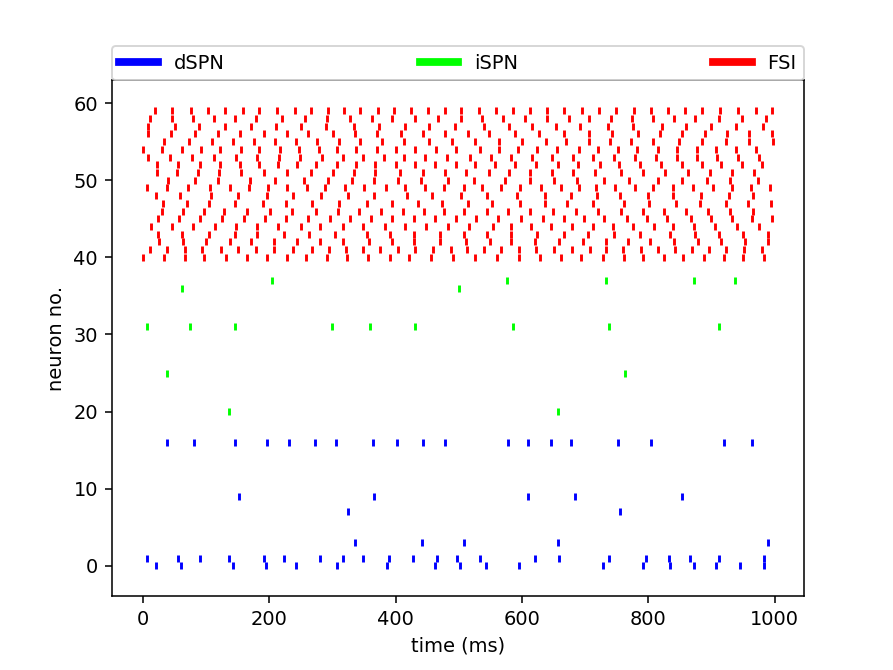

<IPython.core.display.Javascript object>


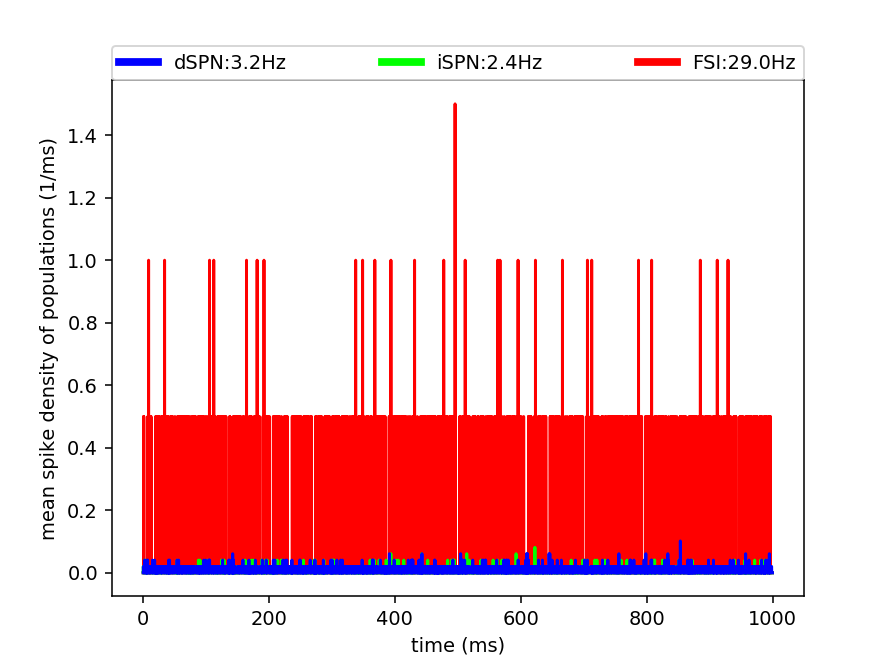

In [13]:
%matplotlib notebook
monitor_ind = create_monitorind([20,20,20]) # randomly chosen monitor indices

run_plot(1000, monitor_ind)

<IPython.core.display.Javascript object>


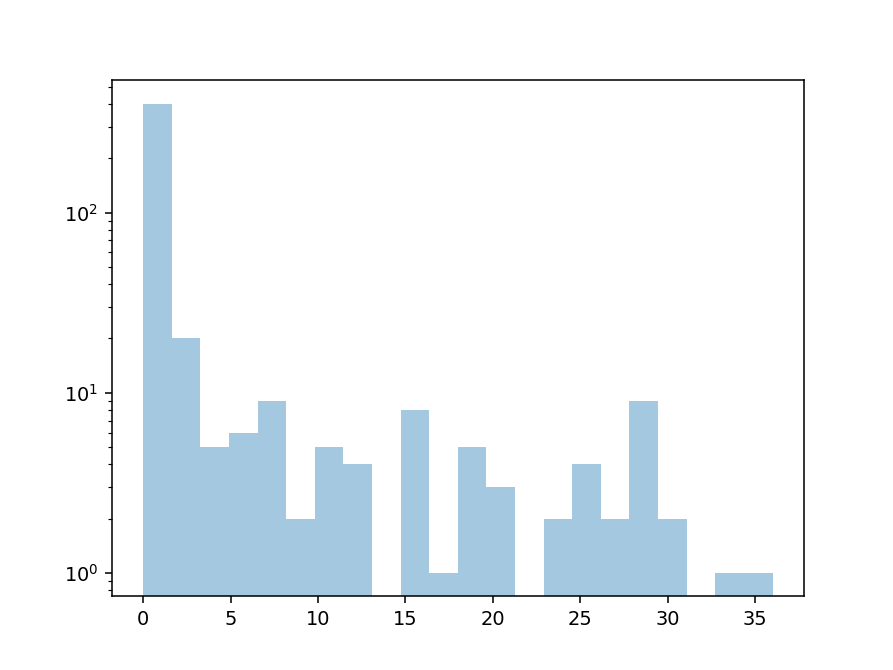

In [20]:
fig, axs = plt.subplots(1,1)
sns.distplot(Neuron.SpikeCount[490:980], kde=False);
axs.set_yscale('log')